# WSI - Zadanie 6 <br/>
### 08.01.2024 <br/>
Wojciech Pobocha
318399,
Mikołaj Sendybył
318402

In [498]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import csv
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

# Wczytywanie i przetwarzanie danych

In [345]:
def splitData(data, ratio):
    np.random.shuffle(data)
    train_size = int(len(data) * ratio)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set, test_set

In [346]:
def timeToMinutes(time):
    splitted = time.split(":")
    if int(splitted[0]) > 23 or int(splitted[1]) > 59:
        raise ValueError
    return int(splitted[0]) * 60 + int(splitted[1])

In [347]:
def processTime(time):
    minutes = timeToMinutes(time)
    return  math.sin(minutes / (24 * 60)*math.pi)

In [348]:
def loadData(codesToIndexes):
    data = []
    for i in range(1, 70):
        filePrefix = 'Diabetes-Data/data-'
        if i < 10:
            filePrefix += '0'
        fileHandle = open(filePrefix+str(i), 'r')
        for line in fileHandle:
            line = line.strip()
            if line:
                try:
                    parts = line.split('\t')
                    time = processTime(parts[1])
                    code = int(parts[2])
                    if code not in codesToIndexes.keys():
                        raise ValueError
                    number = int(parts[3])
                    data.append([time, code, number])
                except ValueError:
                    pass
                except IndexError:
                    pass
        
        fileHandle.close()
    return data


In [349]:
def encodeOutput(Y,codesToIndexes):
    Y_encoded = np.zeros((Y.shape[0], 20))
    for i, code in enumerate(Y):
        index = codesToIndexes[code]
        Y_encoded[i, index] = 1
    return Y_encoded

In [350]:
def getEncodedDatasets():
    codesToIndexes = {33:0, 34:1, 35:2, 48:3, 57:4, 58:5, 59:6, 60:7, 61:8, 62:9, 63:10, 64:11, 65:12, 66:13, 67:14, 68:15, 69:16, 70:17, 71:18, 72:19}
    data = np.array(loadData(codesToIndexes))
    train, test = splitData(data, 0.8)
    X_train = train[:, [0, 2]]
    X_test = test[:, [0, 2]]
    Y_train = train[:, 1]
    Y_test = test[:, 1]
    Y_train_encoded = encodeOutput(Y_train,codesToIndexes)
    Y_test_encoded = encodeOutput(Y_test,codesToIndexes)
    return X_test, Y_test_encoded, X_train, Y_train_encoded

# Inicjalizacja parametrów sieci
## Argumenty funkcji:
- `nX` - ilość wejść sieci,
- `nH` - ilość neuronów w warstwach ukrytych, jeśli > 1 argument ten powinien być listą zawierającą kolejne ilości neuronów,
- `nY` - ilość wyjść sieci
- `numberOfHiddenLayers` - ilość neuronów w warstwie ukrytej - musi zgadzać się z nH.
### Zwraca mapę parametrów

In [351]:
def initializeParameters(nX, nH, nY, numberOfHiddenLayers=1):
    parameters = {}
    if numberOfHiddenLayers < 1:
        raise ValueError   
    if numberOfHiddenLayers == 1:
        parameters["W1"] = np.random.randn(nX, nH)
        parameters["b1"] = np.zeros((1,nH))
    if numberOfHiddenLayers > 1:
        parameters["W1"] = np.random.randn(nX, nH[0])
        parameters["b1"] = np.zeros((1,nH[0]))
        for i in range(2, numberOfHiddenLayers+1):
            parameters["W"+str(i)] = np.random.randn(nH[i-2], nH[i-1])
            parameters["b"+str(i)] = np.zeros((1,nH[i-1]))
    if numberOfHiddenLayers == 1:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH, nY)
    else:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH[-1], nY)
    parameters["b"+str(numberOfHiddenLayers+1)] = np.zeros((1,nY))
    return parameters

### Funkcje aktywacji

- **Warstwy ukryte:** Sigmoid
  - $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- **Warstwa wyjściowa:** Softmax
  - $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Propagacja w przód

Dla każdej warstwy l (od 1 do L+1, gdzie L+1 to warstwa wyjściowa):

1. **Sygnał wejściowy:** $$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
2. **Aktywacja:** 
   - Dla warstw ukrytych: $$A^{[l]} = \sigma(Z^{[l]})$$
   - Dla warstwy wyjściowej: $$A^{[L+1]} = \text{Softmax}(Z^{[L+1]})$$

### Wsteczna propagacja błędu

1. **Błąd na wyjściu (warstwa L+1):**
   - $$\delta^{[L+1]} = A^{[L+1]} - Y$$

Dla każdej warstwy l od L do 1:

2. **Błąd dla warstwy l:**
   - $$\delta^{[l]} = (W^{[l+1]T} \delta^{[l+1]}) \odot \sigma'(Z^{[l]})$$
3. **Gradient dla wag i biasów:**
   - $$\nabla W^{[l]} = \delta^{[l]} A^{[l-1]T}$$
   - $$\nabla b^{[l]} = \sum(\delta^{[l]}, \text{axis} = 0)$$



In [352]:
def costFunction(Y, Y_hat):
    return - np.sum(Y * np.log(Y_hat))

In [353]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [354]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

In [569]:
def propagate(X, Y, parameters):          
    A = X
    history = {"A0": X}
    gradients = {}
    for i in range(1, len(parameters)//2+1):
        Z = np.dot(A, parameters["W"+str(i)]) + parameters["b"+str(i)]
        history["Z"+str(i)] = Z
        if i != len(parameters)//2:
            A = sigmoid(Z)
        else:
            A = softmax(Z)
        history["A"+str(i)] = A
    
    cost = costFunction(Y, A)
    gradients = {}
    
    for i in range(len(parameters)//2, 0, -1):
        if i == len(parameters)//2:
            history["dA"+str(i)]= history["A"+str(i)] - Y
        else:
            history["dA"+str(i)] = np.dot(history["dA"+str(i+1)], parameters["W"+str(i+1)].T) * history["A"+str(i)] * (1 - history["A"+str(i)])
        
        gradients["dW"+str(i)] = np.dot(history["A"+str(i-1)].T,history["dA"+str(i)])
        gradients["db"+str(i)] = np.sum(history["dA"+str(i)], axis=0)
    return gradients, cost


### Aktualizacja wag

- Wagi i biasy są aktualizowane za pomocą metody spadku gradientu:
  - $$W^{[l]} = W^{[l]} - \alpha \nabla W^{[l]}$$
  - $$b^{[l]} = b^{[l]} - \alpha \nabla b^{[l]}$$

In [356]:
def updateParameters(parameters, gradients, learningRate):
    for key in parameters.keys():
        parameters[key] += - learningRate * gradients["d"+key]
    return parameters

In [357]:
def optimize(X, Y, parameters, learningRate, numberOfIterations, printCost=False):
    costs = []
    for i in range(numberOfIterations):
        gradients, cost = propagate(X, Y, parameters)
        parameters = updateParameters(parameters, gradients, learningRate)
        costs.append(cost)
        if i % 100 == 0 and printCost:
            print("Cost after iteration {}: {}".format(i, cost))
    return parameters, costs

In [358]:
def predict(X, parameters):
    Z = X
    for i in range(1, len(parameters)//2):
        Z = np.dot(Z, parameters["W"+str(i)]) + parameters["b"+str(i)]
        Z = sigmoid(Z)
    Z = np.dot(Z, parameters["W"+str(len(parameters)//2)]) + parameters["b"+str(len(parameters)//2)]
    Z = softmax(Z)
    return Z

In [568]:
def writeFileHeader(fileHandle):
    headers = ['Alpha', 'nH', 'Cost','Iterations', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Support',
        'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Support'
    ]
    writer = csv.writer(fileHandle)
    writer.writerow(headers)

In [545]:
def appendRow(filehandle, test, train, alpha, nH, cost, numberOfIterations):
    row = [
        alpha, nH, cost, numberOfIterations,
        test['accuracy'], test['weighted avg']['precision'], test['weighted avg']['recall'], test['weighted avg']['f1-score'], test['weighted avg']['support'],
        train['accuracy'], train['weighted avg']['precision'], train['weighted avg']['recall'], train['weighted avg']['f1-score'], train['weighted avg']['support']
    ]
    writer = csv.writer(filehandle)
    writer.writerow(row)
    

In [574]:
def plot_multiclass_roc(Y, Y_predicted, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = skm.roc_curve(Y[:, i], Y_predicted[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class: {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

In [571]:
def convertYToMaxValuePerRecord(Y):
    return np.argmax(Y, axis=1)

In [584]:
def printMetrics(Y, Y_predicted, roc=True):
    Y_code = convertYToMaxValuePerRecord(Y)
    Y_predicted_code = convertYToMaxValuePerRecord(Y_predicted)
    print("Accuracy: ", skm.accuracy_score(Y_code, Y_predicted_code))
    print("Precision: ", skm.precision_score(Y_code, Y_predicted_code, average='weighted'))
    print("Recall: ", skm.recall_score(Y_code, Y_predicted_code, average='weighted'))
    print("F1: ", skm.f1_score(Y_code, Y_predicted_code, average='weighted'))
    if roc:
        plot_multiclass_roc(Y, Y_predicted, 20)

In [585]:
def runTests(alphasToTest, iterations, nHs, numbersOfHiddenLayers, filename):
    X_test, Y_test, X_train, Y_train =getEncodedDatasets()
    nX = 2
    nY = 20
    if len(nHs) != len(numbersOfHiddenLayers):
        raise ValueError
    with open(filename, 'w', newline='') as fileHandle:
        writeFileHeader(fileHandle)
        for i in range(len(nHs)):
            for alpha in alphasToTest:
                nH = nHs[i]
                numberOfHiddenLayers = numbersOfHiddenLayers[i]
                parameters = initializeParameters(nX, nH, nY,numberOfHiddenLayers)
            
                params, costs = optimize(X_train,Y_train, parameters, alpha, iterations, False)
                Y_train_predicted = predict(X_train, params)
                Y_train_code = convertYToMaxValuePerRecord(Y_train)
                Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
                trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code, output_dict=True)
                Y_test_predicted = predict(X_test, params)
                Y_test_code = convertYToMaxValuePerRecord(Y_test)
                Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
                testReport = skm.classification_report(Y_test_code, Y_test_predicted_code, output_dict=True)
                appendRow(fileHandle, testReport, trainReport, alpha, nH, costs[-1],iterations)

In [586]:
def printTableFromCsv(filePath):
    df = pd.read_csv(filePath)
    df = df.sort_values(by=['Test Accuracy'], ascending=False)
    print(df.to_string(index=False))

In [593]:
def testAndPrintMetrics(nH, numberOfHiddenLayers, alpha, iterations):
    X_test, Y_test, X_train, Y_train =getEncodedDatasets()
    nX = 2
    nY = 20
    if len(nH) != len(numberOfHiddenLayers):
        raise ValueError
    for i in range(len(nH)):
        print("nH: ", nH[i])
        parameters = initializeParameters(nX, nH[i], nY,numberOfHiddenLayers[i])
        params, costs = optimize(X_train,Y_train, parameters, alpha, iterations, False)
        
        print("Test metrics:")
        Y_test_predicted = predict(X_test, params)        
        printMetrics(Y_test, Y_test_predicted)

        print("Train metrics:")
        Y_train_predicted = predict(X_train, params)
        printMetrics(Y_train, Y_train_predicted, False)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.show()

# Zestawienie różnych modeli

In [559]:
alphasToTest = [0.000001,0.00001, 0.0001]
iterations = 5000
nX = 2
nHs = [1,2,5,10,15,20,25,30,100,[20,20],[5,10],[5,15],[10,20],[20,80],[15,5],[6,10,15],[50,50,50]]
nY = 20
numbersOfHiddenLayers = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3]
runTests(alphasToTest, iterations, nHs, numbersOfHiddenLayers, 'results4.csv')

In [561]:
printTableFromCsv('results3.csv')

   Alpha           nH          Cost  Iterations  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Test Support  Train Accuracy  Train Precision  Train Recall  Train F1-Score  Train Support
0.000001 [50, 50, 50]  28046.130530        5000       0.526014        0.426854     0.526014       0.452450        5747.0        0.515834         0.412512      0.515834        0.440967        22988.0
0.000001           30  29624.138750        5000       0.511919        0.433154     0.511919       0.429499        5747.0        0.508178         0.429156      0.508178        0.425159        22988.0
0.000010           10  28243.567090        5000       0.510179        0.413385     0.510179       0.425867        5747.0        0.506090         0.406795      0.506090        0.420463        22988.0
0.000010           15  28393.190846        5000       0.510005        0.418732     0.510005       0.423268        5747.0        0.503654         0.401236      0.503654        0.415802        22988.0
0.000

# Komentarz do zestawienia różnych modeli
Przy porównywaniu powyższych konfiguracji uwydatnia się kilka rzeczy - **alpha = 0.0001** jest zbyt duża, ponieważ wszystkie modele z taką wartością są najgorsze według metryk oceny jakości. Dodatkowo, dla tego problemu zwiększanie ilości neuronów w warstwach ukrytych i samych warstw nie wpływa znacznie na polepszenie modelu, za to zbyt niska ich liczebność powoduje widoczne pogorszenie. Niespodziewaną obserwacją jest fakt, że test accuracy jest wyższa niż train accuracy w większości powyższych modeli.

# Głębsze porównanie metryk oceny jakości kilku wybranych modeli dla większej liczby iteracji

### Porównywane modele: 
- jedna warstwa ukryta z 30 neuronami,
- 2 warstwy ukryte z 10 i 20 neuronami,
- 3 warstwy ukryte po 30 neuronów w każdej.

nH:  30
Test metrics:
Accuracy:  0.5150513311292848
Precision:  0.40656302918543374
Recall:  0.5150513311292848
F1:  0.44424203956394487


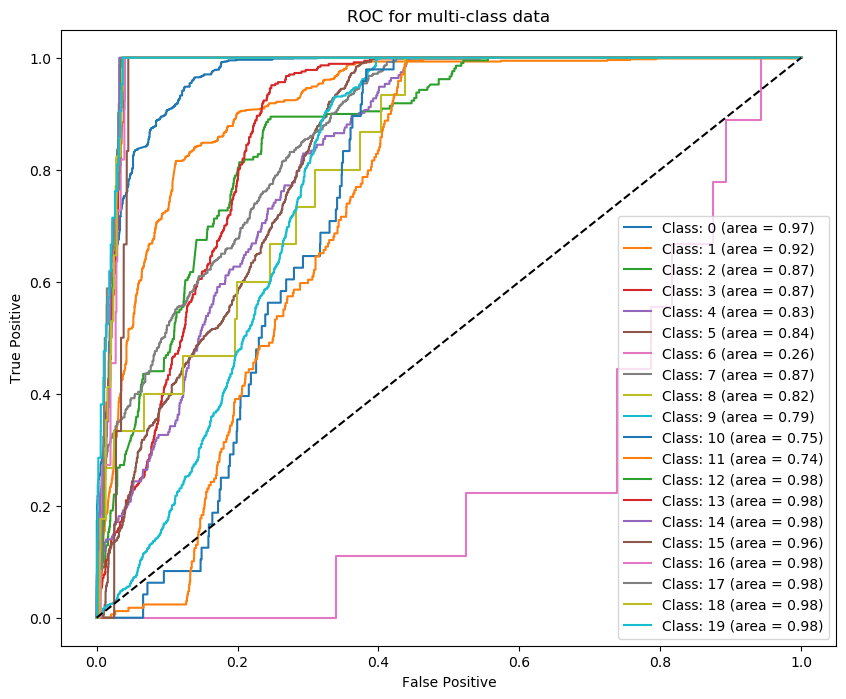

Train metrics:
Accuracy:  0.510396728728032
Precision:  0.39928173875080303
Recall:  0.510396728728032
F1:  0.437450878894096


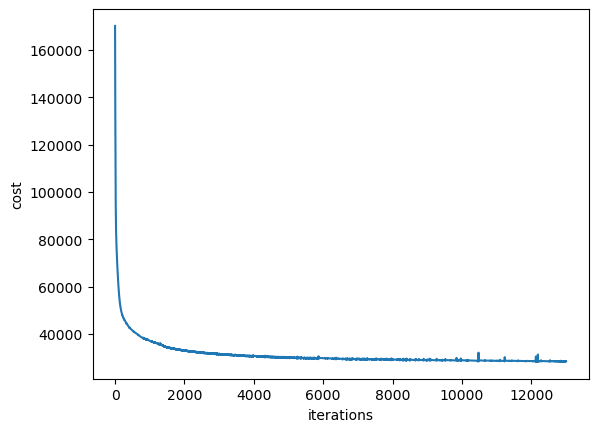

nH:  [10, 20]
Test metrics:
Accuracy:  0.5079171741778319
Precision:  0.41215403944024137
Recall:  0.5079171741778319
F1:  0.4210167414860989


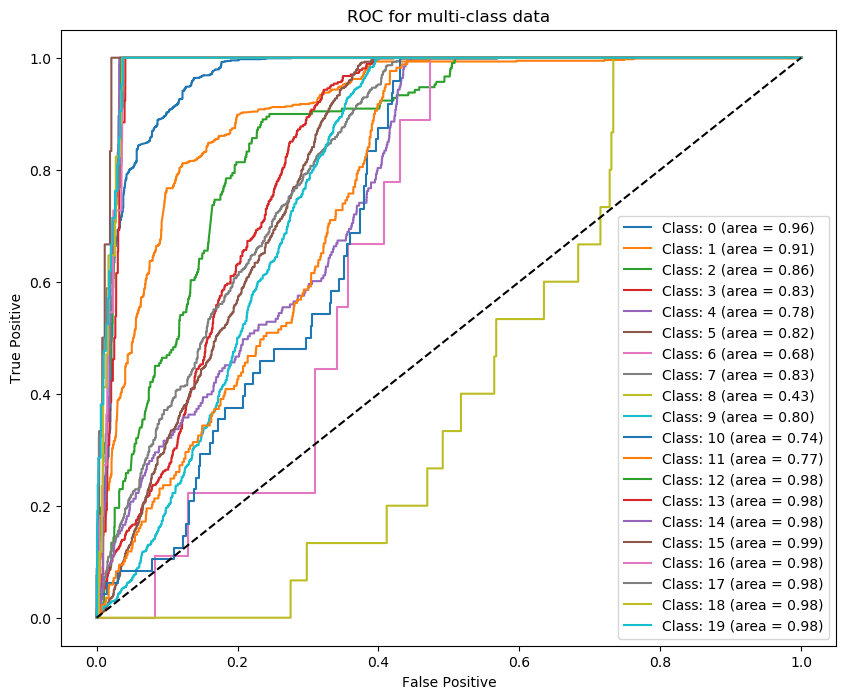

Train metrics:
Accuracy:  0.4984774665042631
Precision:  0.40290653851800057
Recall:  0.4984774665042631
F1:  0.4088240539016035


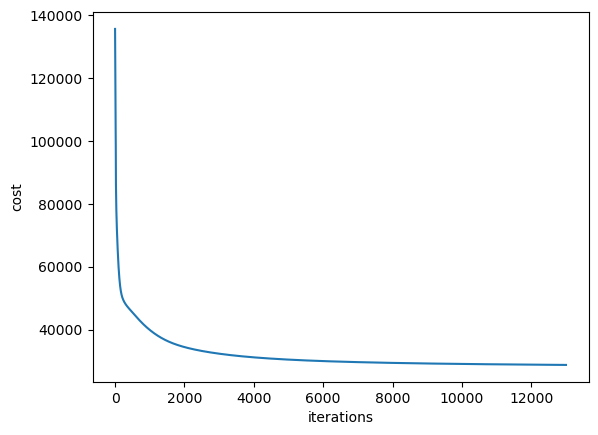

nH:  [30, 30, 30]
Test metrics:
Accuracy:  0.5199234383156429
Precision:  0.4397536825136572
Recall:  0.5199234383156429
F1:  0.4462364265791441


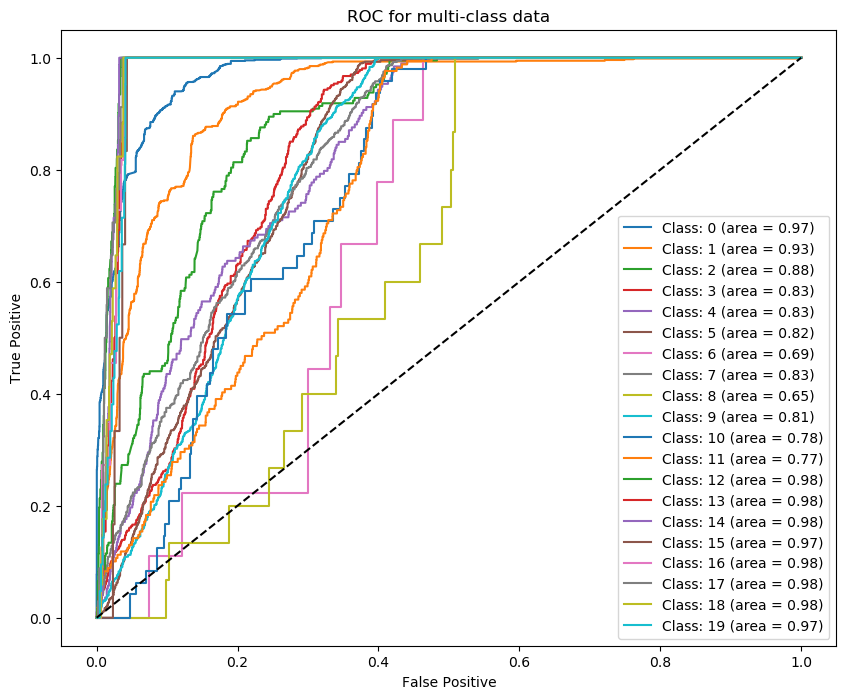

Train metrics:
Accuracy:  0.5104837306420741
Precision:  0.4325400360121815
Recall:  0.5104837306420741
F1:  0.4348690013922354


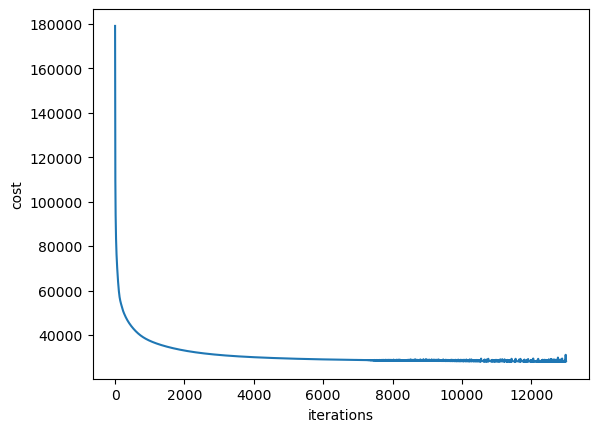

In [595]:
alpha = 0.000001
iterations = 13000
nX = 2
nHs = [30,[10,20],[30,30,30]]
nY = 20
numbersOfHiddenLayers = [1,2,3]

testAndPrintMetrics(nHs, numbersOfHiddenLayers, alpha, iterations)


# Komentarz do porównania trzech modeli o różnych ilościach warstw ukrytych
Przy większych ilościach iteracji wszystkie metryki są podobne do poprzednich, jednak widać drobne ich polepszenie, prawdopodobnie dalsze szkolenie mogłoby pomóc. Nieznacznie gorszy od pozostałych okazał się model sieci z dwoma warstwami ukrytymi. Przy dłuższym szkoleniu dalej widać, że zbiór testowy ma lepsze wyniki niż zbiór treningowy. Dodatkowo, krzywa roc, która obrazuje stosunek true positive do 

# Raport klasyfikacji z biblioteki scikit-learn

In [597]:
X_test, Y_test, X_train, Y_train =getEncodedDatasets()
parameters = initializeParameters(2, 10, 20,1)
params, costs = optimize(X_train,Y_train, parameters, 0.00001, 10000)

Y_train_predicted = predict(X_train, params)

Y_train_code = convertYToMaxValuePerRecord(Y_train)
Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code)

print(trainReport)
Y_test_predicted = predict(X_test, params)

Y_test_code = convertYToMaxValuePerRecord(Y_test)
Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
testReport = skm.classification_report(Y_test_code, Y_test_predicted_code)

print(testReport)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      7476
           1       0.57      0.63      0.60      2922
           2       0.00      0.00      0.00       862
           3       0.00      0.00      0.00      1488
           4       0.00      0.00      0.00       797
           5       0.26      0.99      0.41      2764
           6       0.00      0.00      0.00        14
           7       0.21      0.02      0.04      2222
           8       0.00      0.00      0.00        55
           9       0.02      0.00      0.00      2492
          10       0.00      0.00      0.00       173
          11       0.00      0.00      0.00       714
          12       0.24      0.18      0.21       270
          13       0.00      0.00      0.00       121
          14       0.24      0.71      0.35       274
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        61
          17       0.00    

# Komentarz do raportu klasyfikacji
Badana była sieć z jedną warstwą ukrytą, ponieważ jakość predykcji praktycznie nie różniła się w stosunku do głębszych sieci.
W powyższym raporcie można zaobserwować, że sieć najlepiej przewiduje kody, które występują najczęściej, natomiast większości nie przewiduje w ogóle.